In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from matlab_functions import *

(215, 126)


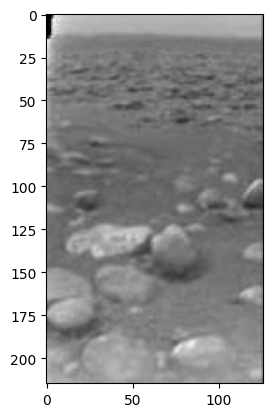

In [2]:
titan = Image.open("titan.jpg")
titan_array = np.array(titan).astype(np.double)
tmax = titan_array.max()
tmin = titan_array.min()
titan_array = titan_array / tmax
print(titan_array.shape)

plt.imshow(titan_array, cmap="gray")
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['figure.dpi'] = 100
plt.show()


## Strategy for project 1

I believe we have to divide the image in a bunch of chunks, at least for the covariance matrix estimation part, since
otherwise it is way to computationally heavy. So we iterate over block of ish 40-50x40-50 and assume regression coefficients for intercept, x and y that are to be estimat and then do the normal procedure with least squares -> covariance estimation -> gls estimation. We then combine all the predictions from the subimages.

### Experiment setup

In [32]:
print(np.sqrt(215**2 + 126**2))
tp = 0.7
used_observations = 10000
titan_1d = titan_array.flatten()

249.20072231034965


### Setting up the seen and missing values, indexes etc

In [33]:

# add X and Y coordinate values
xmax = titan_array.shape[1]
ymax = titan_array.shape[0]
size = 60
spread_x = np.arange(0, xmax)
spread_y = np.arange(0, ymax)
X, Y = np.meshgrid(spread_x, spread_y)
X_cov = X.flatten()
Y_cov = Y.flatten()

covariates = np.vstack((np.ones((X_cov.shape[0])), X_cov, Y_cov)).T

tindex = np.arange(0, titan_array.shape[0]*titan_array.shape[1])
tindex_o = np.random.choice(tindex, size=round(tindex.shape[0]*tp), replace=False)
tindex_o_used = tindex_o[:used_observations]
# Could do smarter sampling above, i.e. instead shuffle tindex as: np.random.shuffle(tindex)
# and then take the first round(tindex.shape[0]*tp) elements
# but setdiff1d seems like a good function to know about.
tindex_m = np.setdiff1d(tindex, tindex_o)

observed_values = titan_1d[tindex_o]
observed_values_used = titan_1d[tindex_o_used]
missing_values = titan_1d[tindex_m]

# dist matrix and stuff for variogram estimation
loc = np.column_stack((X_cov, Y_cov))

loc_o = loc[tindex_o, :]
loc_o_used = loc[tindex_o_used, :]
loc_m = loc[tindex_m, :]
covariates_o = covariates[tindex_o, :]
covariates_o_used = covariates[tindex_o_used, :]
covariates_m = covariates[tindex_m, :]
print(loc)


[[  0   0]
 [  1   0]
 [  2   0]
 ...
 [123 214]
 [124 214]
 [125 214]]


### Estimating parameters with OLS for variogram estimation

In [34]:
# estimate parameters LSE then GLS

lse = np.linalg.solve(covariates_o_used.T @ covariates_o_used, covariates_o_used.T @ observed_values_used)
e = observed_values_used - covariates_o_used @ lse
print(lse)

[ 4.85999073e-01 -3.28563843e-04  2.74012401e-04]


### Empirical variogram

In [35]:
emp_v = emp_variogram(loc_o_used, e, 100)

### LSE of variogram parameters

In [36]:
# they say to fix nu to 1.0, but I don't know why, and it seems to make the fit worse
lse_estimates = cov_ls_est(e, 'matern' , emp_v) #Least-squares estimation of a Matern variogram to the binned estimate

lse_estimates_nu_fixed = cov_ls_est(e, 'matern' , emp_v, {"nu": 1.0})

h = np.linspace(0, 250, 1000)
mat_v_new = matern_variogram(h,lse_estimates["sigma"],lse_estimates["kappa"], lse_estimates["nu"], lse_estimates["sigma_e"])
mat_v_new_nu_fixed = matern_variogram(h,lse_estimates_nu_fixed["sigma"],lse_estimates_nu_fixed["kappa"], lse_estimates_nu_fixed["nu"], lse_estimates_nu_fixed["sigma_e"])
print("nu not fixed", lse_estimates)
print("nu fixed = 1", lse_estimates_nu_fixed)


nu not fixed {'sigma': 0.8574987853422588, 'kappa': 1.2995003775255064e-06, 'nu': 0.23683301627642941, 'sigma_e': 0.04231043318966584}
nu fixed = 1 {'nu': 1.0, 'sigma': 0.10967456561106871, 'kappa': 0.012209314659089468, 'sigma_e': 0.07832028084441282}


### PLot of variogram estimations

ValueError: x and y must have same first dimension, but have shapes (99,) and (1000,)

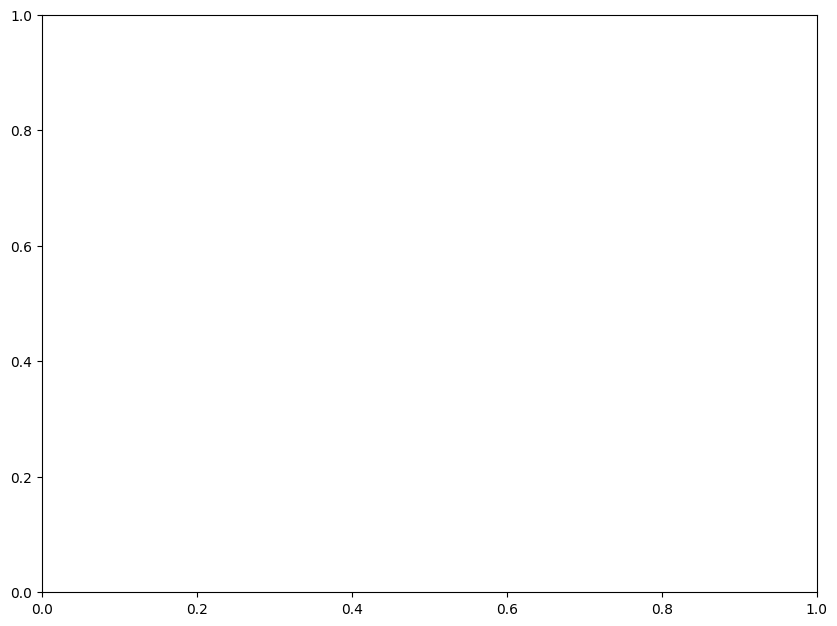

In [43]:
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
plt.plot(emp_v["h"],mat_v_new, color="orange")
plt.plot(emp_v["h"],mat_v_new_nu_fixed, color="red")
plt.plot(emp_v["h"], emp_v["variogram"],'o')
plt.legend(["Estimated variogram", "Estimated variogram nu fixed = 1", "Binned estimate"])
plt.show()
#Estimated variogram
#True vs Estimated variogram


### Covariance matrix for observed values

In [37]:
# Covariance matrix
So = np.zeros((loc_o_used.shape[0], loc_o_used.shape[0]))
for i in range(loc_o_used.shape[0]):
    So[i, i:] = matern_covariance(np.sqrt(np.sum((loc_o_used[i, :] - loc_o_used[i:, :])**2, axis=1)) , lse_estimates["sigma"], lse_estimates["kappa"], lse_estimates["nu"])

So = So + np.triu(So, k=1).T
# For memory reasons, we can delete the distance matrix Do


#### Adding the nugget

In [38]:
So = (lse_estimates["sigma_e"]**2) * np.eye(loc_o_used.shape[0]) + So

In [59]:
#So = So - (lse_estimates["sigma_e"]**2) * np.eye(loc_o_used.shape[0])

In [71]:
So

array([[0.01615065, 0.00435515, 0.00550882, ..., 0.00569657, 0.00246012,
        0.00686715],
       [0.00435515, 0.01615065, 0.00419677, ..., 0.00892023, 0.00362982,
        0.0029943 ],
       [0.00550882, 0.00419677, 0.01615065, ..., 0.00563114, 0.0056101 ,
        0.00283436],
       ...,
       [0.00569657, 0.00892023, 0.00563114, ..., 0.01615065, 0.00415134,
        0.00361139],
       [0.00246012, 0.00362982, 0.0056101 , ..., 0.00415134, 0.01615065,
        0.001223  ],
       [0.00686715, 0.0029943 , 0.00283436, ..., 0.00361139, 0.001223  ,
        0.01615065]])

### GLS estimation of parameters for spatial regression

In [39]:
gls = np.linalg.solve(covariates_o_used.T @ np.linalg.solve(So, covariates_o_used), covariates_o_used.T @ np.linalg.solve(So, observed_values_used))

In [29]:
print(gls)
print(lse)

[ 5.87486077e-01 -4.46735607e-04  1.35532056e-04]
[ 4.91049307e+01 -3.90765654e-02  2.69583786e-02]


### Setup for kriging, calculate Sop

In [40]:
from scipy.spatial import distance_matrix

Dom = distance_matrix(loc_o_used, loc_m)
Som = np.zeros([loc_o_used.shape[0], loc_m.shape[0]])
half = loc_m.shape[0]//2
for i in range(loc_o_used.shape[0]):
    Som[i, :half] = matern_covariance(Dom[i, :half],
                          lse_estimates['sigma'], 
                          lse_estimates['kappa'],
                          lse_estimates['nu'])
    Som[i, half:] = matern_covariance(Dom[i, half:],
                          lse_estimates['sigma'], 
                          lse_estimates['kappa'],
                          lse_estimates['nu'])

Dom = None

### Kriging predictions

In [41]:
#krig = covariates_m @ gls + Som.T @ np.linalg.solve(So, observed_values_used - covariates_o_used @ gls)
krig = covariates_m @ gls + Som.T @ np.linalg.solve(So, observed_values_used - covariates_o_used @ gls)

In [64]:
krig

array([0.15338493, 0.2468959 , 0.35986973, ..., 0.56155173, 0.53502853,
       0.511316  ])

In [76]:
krig

array([0.49026156, 0.52365637, 0.54387299, ..., 0.62640609, 0.6257028 ,
       0.62469353])

### Plotting results

8141
18949
[0.3398086  0.80581044 0.77399713 ... 0.60450432 0.59871598 0.56561582]


(-0.5, 125.5, 214.5, -0.5)

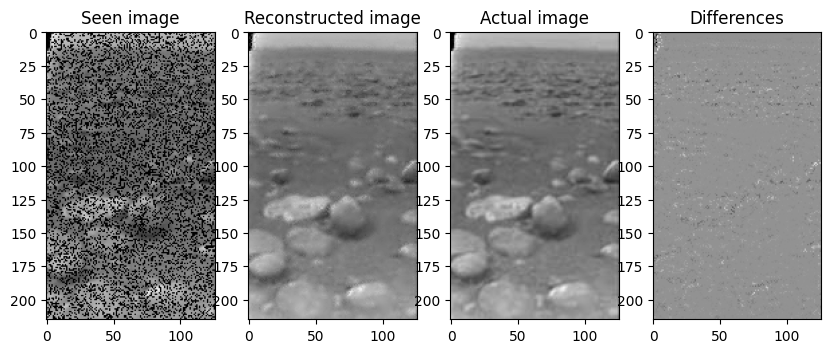

In [42]:
seen_image = titan_array.flatten()
seen_image[tindex_m] = 0
print((seen_image == 0).sum())
print((seen_image != 0).sum())

Reconstructed_image = np.zeros((titan_array.shape[0]*titan_array.shape[1], ))
Reconstructed_image[tindex_o] = observed_values
Reconstructed_image[tindex_m] = krig
print(Reconstructed_image[tindex_m])

plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(1, 4)
ax[0].imshow(seen_image.reshape(titan_array.shape[0], titan_array.shape[1]), cmap="gray")
ax[0].set_title("Seen image")
ax[0].axis('image')
ax[1].imshow(Reconstructed_image.reshape(titan_array.shape[0], titan_array.shape[1]), cmap="gray")
ax[1].set_title("Reconstructed image")
ax[1].axis('image')
ax[2].imshow(titan_1d.reshape(titan_array.shape[0], titan_array.shape[1]), cmap="gray")
ax[2].set_title("Actual image")
ax[2].axis('image')
ax[3].imshow((titan_1d - Reconstructed_image).reshape(titan_array.shape[0], titan_array.shape[1]), cmap="gray")
ax[3].set_title("Differences")
ax[3].axis('image')